In [5]:
import MDAnalysis as mda
import pandas as pd
import numpy as np
import os
import itertools 
from iupac_to_mapping import string_process
from iupac_to_mapping import iupac_converter

from MDAnalysis.analysis.dihedrals import Dihedral

from MDAnalysis.analysis.base import (AnalysisBase,
                                      AnalysisFromFunction,
                                      analysis_class)
from iupac_to_mapping import compute_torsions
from iupac_to_mapping import glycan_chain_indices
# import nglview as nv
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget
# import IPython
from IPython.core.display import Image
# import nglview as nv
import pprint

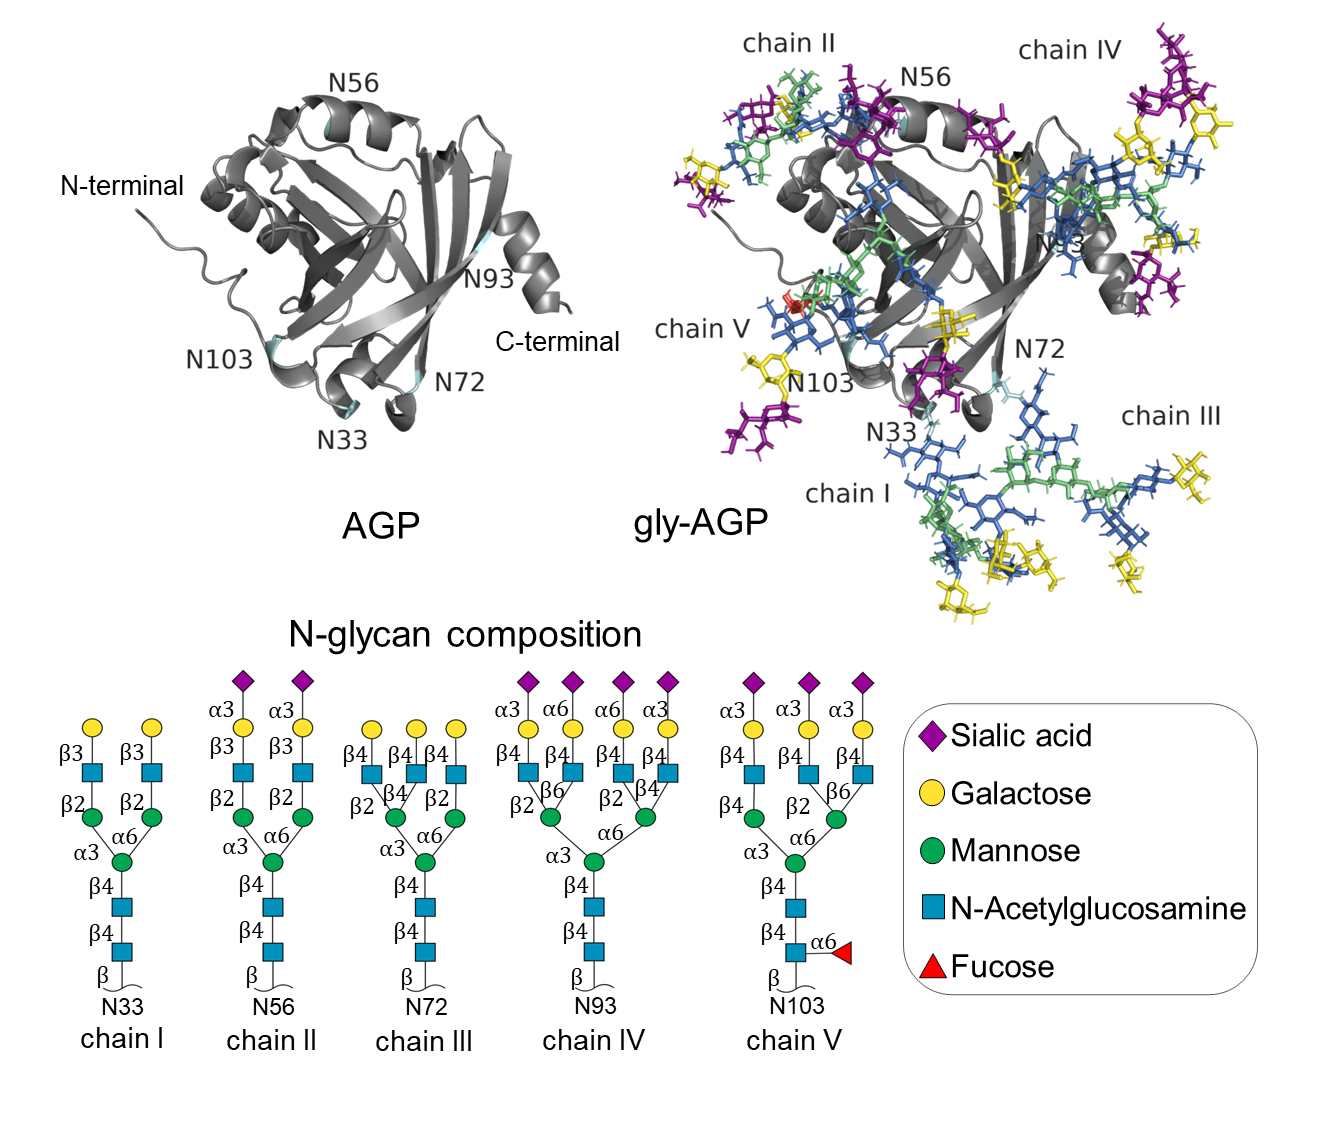

In [3]:
Image('./Figure1.png')

## convert Glycan IUPAC sequence to structure mapping with accurate indexing

In [6]:
iupac_string = {'chain I':"Gal(b1-3)GlcNAc(b1-2)Man(a1-3)[Gal(b1-3)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc(b1-",
 'chain II': "Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc(b1-", 
 'chain III': "Gal(b1-4)GlcNAc(b1-2)[Gal(b1-4)GlcNAc(b1-4)]Man(a1-3)[Gal(b1-3)GlcNAc(b1-2)Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc(b1-",
 'chain IV': "Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-6)]Man(a1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc(b1-",
 'chain V': "Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-4)Man(a1-3)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)[Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-6)]Man(a1-6)]Man(b1-4)GlcNAc(b1-4)[D-Fuc(a1-6)]GlcNAc(b1-"}

# five glycosylation sites in AGP
glysites = [x for x in [15, 38, 54, 75, 85]]
core = ['BGLCN', 'BGLCN', 'BMAN']      # core is pre-defined based on GROMACS naming convention of glycans
global iupac_string
global glysites

glycan_processor = string_process.GlycanProcessor(iupac_string, glysites)
g_format_dict = glycan_processor.process_glycan()
g_triplet_dict = glycan_processor.core_triplet_dict(g_format_dict)


glycan_analyzer = iupac_converter.GlycanAnalyzer(g_format_dict, g_triplet_dict, glycan_processor)
glycan_analyzer.branch_processing()
# print(glycan_analyzer)
structure_mapping = glycan_analyzer.structure_mapping()
pprint.pprint(structure_mapping)

chain I
Branch 1: ['Gal b1-3 GlcNAc b1-2 Man a1-3']
Branch 2: ['Gal b1-3 GlcNAc b1-2 Man a1-6 ']

chain II
Branch 1: ['Neu5Ac a2-3 Gal b1-4 GlcNAc b1-2 Man a1-3']
Branch 2: ['Neu5Ac a2-3 Gal b1-4 GlcNAc b1-2 Man a1-6 ']

chain III
Branch 1: {'Sub-core': ['Man a1-3'], 'Sub-branch': ['Gal b1-4 GlcNAc b1-2', 'Gal b1-4 GlcNAc b1-4 ']}
Branch 2: ['Gal b1-3 GlcNAc b1-2 Man a1-6 ']

chain IV
Branch 1: {'Sub-core': ['Man a1-3'], 'Sub-branch': ['Neu5Ac a2-3 Gal b1-4 GlcNAc b1-2', 'Neu5Ac a2-6 Gal b1-4 GlcNAc b1-6 ']}
Branch 2: {'Sub-core': ['Man a1-6 '], 'Sub-branch': ['Neu5Ac a2-6 Gal b1-4 GlcNAc b1-2', 'Neu5Ac a2-3 Gal b1-4 GlcNAc b1-4 ']}

chain V
Branch 1: ['Neu5Ac a2-3 Gal b1-4 GlcNAc b1-4 Man a1-3']
Branch 2: {'Sub-core': ['Man a1-6 '], 'Sub-branch': ['Neu5Ac a2-3 Gal b1-4 GlcNAc b1-2', 'Neu5Ac a2-3 Gal b1-4 GlcNAc b1-6 ']}
remaining branch: ['D-Fuc a1-6 ']

Gal b1-3 GlcNAc b1-2 Man a1-3
Neu5Ac a2-3 Gal b1-4 GlcNAc b1-2 Man a1-3
Neu5Ac a2-3 Gal b1-4 GlcNAc b1-4 Man a1-3
{'chain I':   glyc

In [8]:
filepath = os.path.join(os.getcwd(), 'input_example')
gro_file = mda.Universe(os.path.join(filepath, 'example.gro'))
glycan_atoms = gro_file.select_atoms('not protein and not resname SOD and not resname CLA and not resname TIP3')
glycan_atoms

<AtomGroup with 1606 atoms>

In [9]:
glycan_ind = glycan_chain_indices.GlycanStructure(glycan_atoms, core).find_indices()

## Compute glycan torsions based on mapping

In [10]:
torsion_obj = compute_torsions.GlycanTorsions(iupac_string, glysites, gro_file, glycan_ind, structure_mapping)

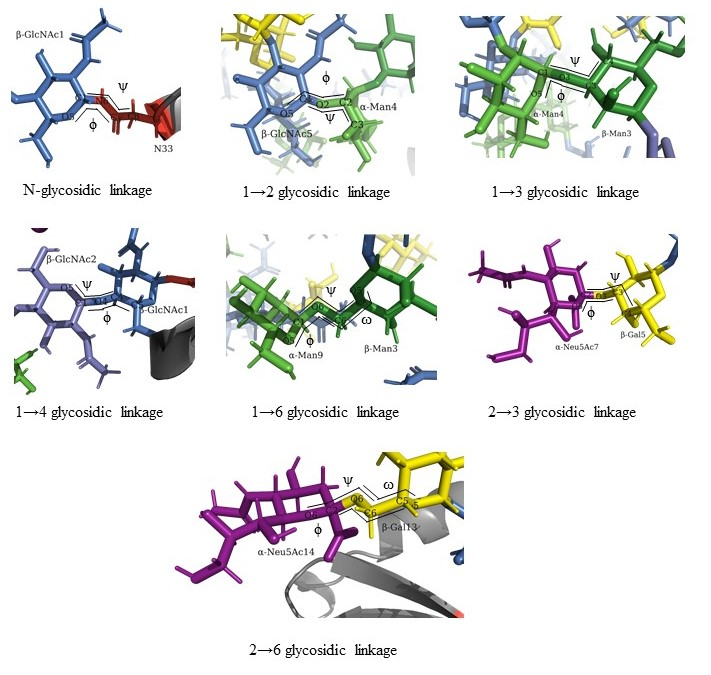

In [11]:
Image('./FigureS23.jpg')

In [12]:
torsion_obj.glycan_torsions(torsion='phi', traj=None)

{'chain I': {'BGLCN1(1-)ASN_15': -79.2963665228457,
  'BGLCN2(1-4)BGLCN1': -64.35911529217032,
  'BMAN3(1-4)BGLCN2': -86.16162287404461,
  'AMAN4(1-3)BMAN3': 72.79652171147747,
  'BGLCN5(1-2)AMAN4': -71.87140128566972,
  'BGAL6(1-3)BGLCN5': -71.52379862782179,
  'AMAN7(1-6)BGAL6': -129.58929407462543,
  'BGLCN8(1-2)AMAN7': -90.74397632433988,
  'BGAL9(1-3)BGLCN8': -79.59305824309538},
 'chain II': {'BGLCN10(1-)ASN_38': -71.70533457150316,
  'BGLCN11(1-4)BGLCN10': -90.37848871226144,
  'BMAN12(1-4)BGLCN11': -68.78005496928179,
  'AMAN13(1-3)BMAN12': 85.94658500642572,
  'BGLCN14(1-2)AMAN13': -56.635997633734824,
  'BGAL15(1-4)BGLCN14': -66.52851037481223,
  'ANE5A16(2-3)BGAL15': -48.10495949848589,
  'AMAN17(1-6)ANE5A16': -124.46372281371846,
  'BGLCN18(1-2)AMAN17': -51.19043353666791,
  'BGAL19(1-4)BGLCN18': -78.13070264294376,
  'ANE5A20(2-3)BGAL19': 77.71381206422271},
 'chain III': {'BGLCN21(1-)ASN_54': -54.94547884511114,
  'BGLCN22(1-4)BGLCN21': -72.3188057028266,
  'BMAN23(1-4)BG

In [13]:
torsion_obj.glycan_torsions(torsion='psi', traj=None)

{'chain I': {'BGLCN1(1-)ASN_15': 161.5727760052869,
  'BGLCN2(1-4)BGLCN1': 105.39873826543057,
  'BMAN3(1-4)BGLCN2': -128.75532104549697,
  'AMAN4(1-3)BMAN3': 129.61934014260328,
  'BGLCN5(1-2)AMAN4': 147.04196119483112,
  'BGAL6(1-3)BGLCN5': 109.26813442454308,
  'AMAN7(1-6)BGAL6': -35.56584914386961,
  'BGLCN8(1-2)AMAN7': 157.91484425229197,
  'BGAL9(1-3)BGLCN8': 105.33209132707574},
 'chain II': {'BGLCN10(1-)ASN_38': 166.48439129700245,
  'BGLCN11(1-4)BGLCN10': 112.4745090364181,
  'BMAN12(1-4)BGLCN11': -123.67253572911387,
  'AMAN13(1-3)BMAN12': -22.690918023020302,
  'BGLCN14(1-2)AMAN13': 168.8979100256406,
  'BGAL15(1-4)BGLCN14': -121.97477933051422,
  'ANE5A16(2-3)BGAL15': 99.99476087166938,
  'AMAN17(1-6)ANE5A16': -8.010903508554543,
  'BGLCN18(1-2)AMAN17': 170.71915514114067,
  'BGAL19(1-4)BGLCN18': -142.66790907610792,
  'ANE5A20(2-3)BGAL19': 102.184921600541},
 'chain III': {'BGLCN21(1-)ASN_54': 172.74358707901297,
  'BGLCN22(1-4)BGLCN21': -116.76163618517126,
  'BMAN23(1-4)